# Juliaで信号処理の練習
## シュレーダー式リバーブ
シュレーダーリバーブについては，こちらを参照[[Link]](http://www.ari-web.com/service/soft/reverb-2.htm)

リングバッファを使いたいので[DataStructures.jl](https://github.com/JuliaCollections/DataStructures.jl)を使用

In [1]:
using DataStructures

フィードバックコムフィルタとオールパスフィルタを用意  
パラメータの種類は共通で伝達関数が違うだけなので，1種類のパラメータ保持用の構造体とそれを受ける2種類の関数を作る．

In [2]:
struct FilterState{T}
    inbuff::CircularBuffer{T}
    outbuff::CircularBuffer{T}
    τ::Int
    g::Real

    function FilterState{T}(τsec, g, fs) where T <: AbstractFloat
        τ = floor(Int, τsec * fs)
        inbuff = CircularBuffer{T}(τ)
        outbuff = CircularBuffer{T}(τ)
        while !isfull(inbuff)
            push!(inbuff, 0.0)
            push!(outbuff, 0.0)
        end
    
        new{T}(inbuff, outbuff, τ, g)
    end
end

In [3]:
function fbcomb!(sys::FilterState, u::Real)
    τ = sys.τ - 1
    y = sys.inbuff[end - τ] + sys.g * sys.outbuff[end - τ]
    push!(sys.inbuff, u)
    push!(sys.outbuff, y)
    
    return y
end

fbcomb! (generic function with 1 method)

In [4]:
function allpass!(sys::FilterState, u::Real)
    τ = sys.τ - 1
    y = -sys.g * u + sys.inbuff[end - τ] + sys.g * sys.outbuff[end - τ]
    push!(sys.inbuff, u)
    push!(sys.outbuff, y)
    return y
end

allpass! (generic function with 1 method)

リバーブ自体はコム・オールパスフィルタの集まりなのでそれらをコンポジションで持たせる

In [5]:
struct Reverbrator
    combfilts::Array{FilterState, 1}
    apfilts::Array{FilterState, 1}
    wet::Real
end

1サンプルだけ処理する場合

In [6]:
function process!(sys::Reverbrator, u::Real)
    y = 0.0
    
    for cf in sys.combfilts
        y += fbcomb!(cf, u) 
    end
    
    for ap in sys.apfilts
        y = allpass!(ap, y)
    end
    
    return y * sys.wet + u * (1.0 - sys.wet)
end

process! (generic function with 1 method)

入力オーディオデータをまとめて処理する場合

In [7]:
function process!(sys::Reverbrator, u::Array{T, 1}) where T <: Real
    y = Array{T}(length(u))
    
    for i in 1:length(u)
        y[i] = process!(sys, u[i])
    end
    
    return y
end

process! (generic function with 2 methods)

In [8]:
fs = 48000.0
τcomb = [39.85, 36.10, 33.27, 30.15] / 1000.0
gcomb = [0.87, 0.88, 0.89, 0.90]
combfilts = [FilterState{Float64}(τ, g, fs) for (τ, g) in zip(τcomb, gcomb)]

τap = [5.0, 1.7] / 1000.0
gap = [0.7, 0.7]
apfilts = [FilterState{Float64}(τ, g, fs) for (τ, g) in zip(τap, gap)]

reverb = Reverbrator(combfilts, apfilts, 1.0)

Reverbrator(FilterState[FilterState{Float64}([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 1912, 0.87), FilterState{Float64}([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 1732, 0.88), FilterState{Float64}([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 1596, 0.89), FilterState{Float64}([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 1447, 0.9)], 

In [9]:
N = fs*2
δ(n) = n == 0.0 ? 1.0 : 0.0
inbuff = [δ(i) for i in 0:N-1]
outbuff = process!(reverb, inbuff)

96000-element Array{Float64,1}:
  0.0        
  0.0        
  0.0        
  0.0        
  0.0        
  0.0        
  0.0        
  0.0        
  0.0        
  0.0        
  0.0        
  0.0        
  0.0        
  ⋮          
 -6.3667e-5  
 -2.06103e-5 
  1.01959e-6 
  4.92799e-10
  3.33438e-8 
  4.99598e-7 
  2.41092e-10
  1.63385e-8 
  2.44803e-7 
  1.18226e-10
  8.00587e-9 
 -1.15144e-7 

In [11]:
using Plots
pyplot()

Plots.PyPlotBackend()


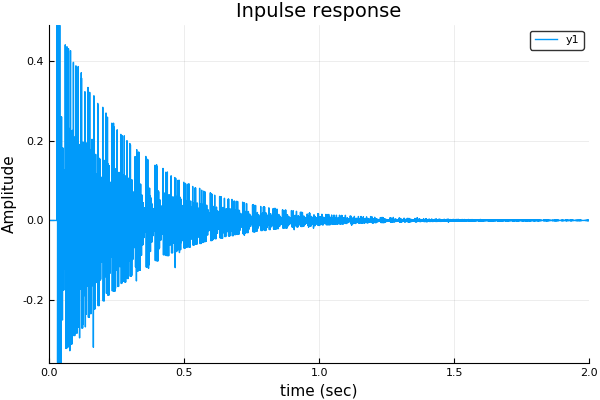

In [12]:
t = [i / fs for i in 0 : length(outbuff - 1)]
plot(t, outbuff, title = "Inpulse response", xlabel = "time (sec)", ylabel = "Amplitude")